In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm, transforms
import geopandas as gpd
import locale
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.patheffects as pe

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.grid'] = False
sns.set(font_scale=1.5)

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_5.csv.gz")
df.head(2)

/tmp/ipykernel_19160/1172278971.py:1: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{BASE}work_data/matriz_desercion_5.csv.gz")


,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,jornada,dur_estudio_carr,dur_proceso_tit,...,acreditada_inst,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio,fscu,gratuidad,beca,decil
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Vespertino,5,1.0,...,ACREDITADA,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Vespertino,5,1.0,...,ACREDITADA,0.0,13,310.0,4.975,3.0,0.0,0.0,0.0,6.0


# Deserción

In [3]:
df["anio_desercion"] = df["cat_periodo"] + 1

In [4]:
porc_des = pd.DataFrame(df.groupby(["anio_desercion"])["desertor_1"].value_counts("%").rename("%") * 100).reset_index()
porc_des = porc_des[porc_des["desertor_1"]==1]
porc_des

,anio_desercion,desertor_1,%
1,2016,1.0,16.368109
3,2017,1.0,14.418847
5,2018,1.0,13.360973
7,2019,1.0,13.062208
9,2020,1.0,15.068913
11,2021,1.0,16.939409
13,2022,1.0,24.696973


# Acreditación carrera

In [5]:
df.columns

Index(['cat_periodo', 'codigo_unico', 'mrun', 'gen_alu', 'fec_nac_alu',
       'anio_ing_carr_ori', 'tipo_inst_1', 'region_sede', 'valor_arancel',
       'area_conocimiento', 'acreditada_carr', 'acreditada_inst', 'desertor_1',
       'region_colegio', 'tipo_ensenanza_colegio', 'prom_notas_media',
       'dependencia_colegio', 'cant_becas', 'anio_desercion'],
      dtype='object')

In [6]:
cantidades_acc = df[df["anio_desercion"] < 2021][
    ["anio_desercion", "mrun", "desertor_1", "acreditada_carr"]
].drop_duplicates().groupby(["anio_desercion", "acreditada_carr"]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()#.groupby(["Region"]).agg({"mrun": "mean","desertor_1": "mean"}).reset_index().round()

cantidades_acc.head()

,anio_desercion,acreditada_carr,mrun,desertor_1
0,2016,ACREDITADA,82830,11332.0
1,2016,NO ACREDITADA,102408,19007.0
2,2017,ACREDITADA,151431,18322.0
3,2017,NO ACREDITADA,158467,26332.0
4,2018,ACREDITADA,216733,24432.0


In [7]:
cantidades_acc["desertor_1_porc"] = [
    (d / cantidades_acc[
        (cantidades_acc["anio_desercion"] == a)
        & (cantidades_acc["acreditada_carr"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades_acc["anio_desercion"], cantidades_acc["desertor_1"], cantidades_acc["acreditada_carr"])
]

cantidades_acc.head()

,anio_desercion,acreditada_carr,mrun,desertor_1,desertor_1_porc
0,2016,ACREDITADA,82830,11332.0,13.681033
1,2016,NO ACREDITADA,102408,19007.0,18.560073
2,2017,ACREDITADA,151431,18322.0,12.099240
3,2017,NO ACREDITADA,158467,26332.0,16.616709
4,2018,ACREDITADA,216733,24432.0,11.272856


In [8]:
# # create the colorbar
norm = colors.Normalize(vmin=cantidades_acc["desertor_1_porc"].min(), vmax=cantidades_acc["desertor_1_porc"].max())
colores = cm.get_cmap('coolwarm', 256)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=colores)

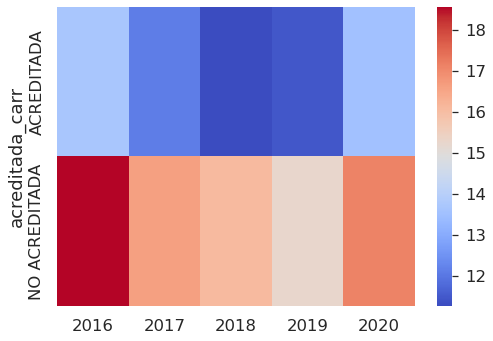

In [9]:
t_acc = cantidades_acc[["anio_desercion", "acreditada_carr", "desertor_1_porc"]]
piv_acc = pd.pivot_table(
    t_acc, values="desertor_1_porc", index=["anio_desercion"], columns=["acreditada_carr"]
).reset_index().T
piv_acc = piv_acc.rename(columns=piv_acc.iloc[0].astype(int))[1:].reindex(index=cantidades_acc['acreditada_carr'].unique())
sns.heatmap(piv_acc, cmap="coolwarm");

In [12]:
melted_acc= pd.melt(piv_acc.T, value_vars=cantidades_acc['acreditada_carr'].unique())
model_acc = smf.ols('value ~ C(acreditada_carr)', data=melted_acc).fit()
resumen_acc = model_acc.summary2()
resumen_acc.tables[0]

/home/giani/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.780
1,Dependent Variable:,value,AIC:,33.5824
2,Date:,2022-10-12 10:31,BIC:,34.1875
3,No. Observations:,10,Log-Likelihood:,-14.791
4,Df Model:,1,F-statistic:,32.96
5,Df Residuals:,8,Prob (F-statistic):,0.000433
6,R-squared:,0.805,Scale:,1.4099


In [14]:
coefs_acc = resumen_acc.tables[1]
coefs_acc[coefs_acc["P>|t|"] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,12.411336,0.531013,23.372926,1.193386e-08,11.186817,13.635855
C(acreditada_carr)[T.NO ACREDITADA],4.311544,0.750966,5.741328,4.332848e-04,2.579813,6.043276


### Proporción matrículas únicas

In [7]:
df_s = df[df["anio_desercion"] < 2021].sort_values(
    by=["mrun", "codigo_unico", "desertor_1"], ascending=[False, False, False]
).drop_duplicates(subset=["mrun", "codigo_unico"], keep="first").copy()

cross_tab_prop = pd.crosstab(index=df_s['acreditada_carr'],
                             columns=df_s['desertor_1'],
                             normalize="index")

cross_tab = pd.crosstab(index=df_s['acreditada_carr'],
                        columns=df_s['desertor_1'])

print(df_s.shape)
cross_tab#527046, 505282

(1032311, 26)


desertor_1,0.0,1.0
acreditada_carr,,
ACREDITADA,406725,120321
NO ACREDITADA,369073,136192


In [81]:
sample_success_a, sample_size_a = (120321, 527046)
sample_success_b, sample_size_b = (136204, 505282)

successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

(-48.502534900741956, 0.0)

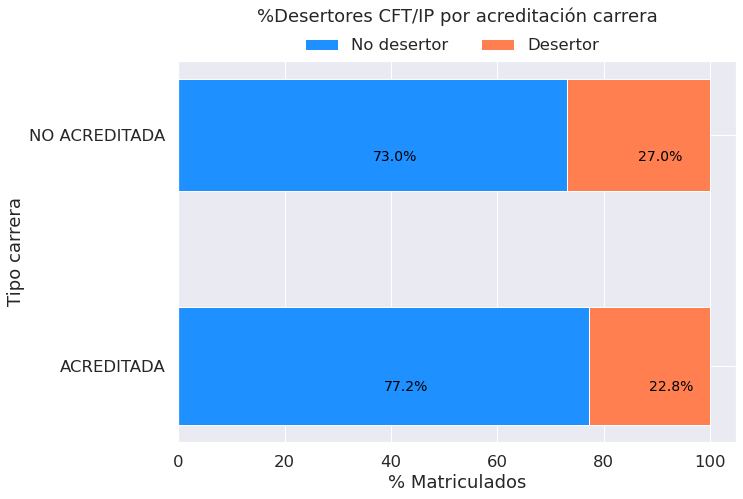

In [83]:
w = list(cross_tab.T.sum()/cross_tab.T.sum().sum())

f, ax = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 15})

plt.title("%Desertores CFT/IP por acreditación carrera", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['acreditada_carr'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['acreditada_carr'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Tipo carrera");

## Acreditación institución
### Proporción matrículas únicas

In [84]:
cross_tab_prop = pd.crosstab(index=df_s['acreditada_inst'],
                             columns=df_s['desertor_1'],
                             normalize="index")

cross_tab = pd.crosstab(index=df_s['acreditada_inst'],
                        columns=df_s['desertor_1'])

cross_tab#890380, 141948

desertor_1,0.0,1.0
acreditada_inst,,
ACREDITADA,682108,208272
NO ACREDITADA,93695,48253


In [85]:
successes = np.array([208272, 48253])
samples = np.array([890380, 141948])

proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

(-85.84429026598534, 0.0)

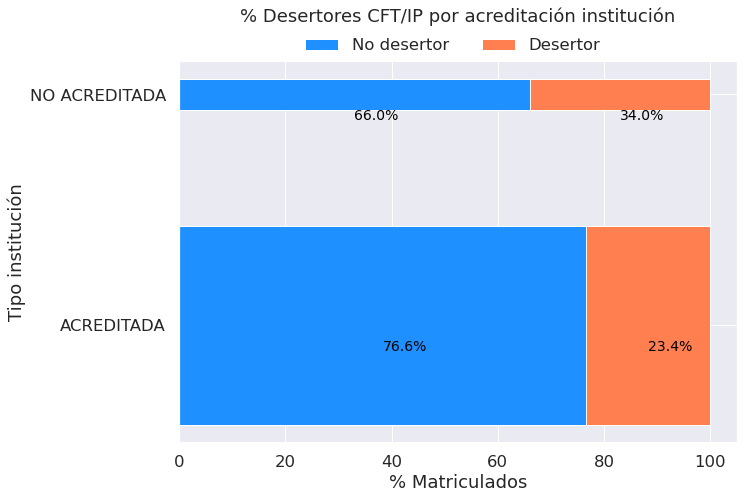

In [86]:
w = list(cross_tab.T.sum()/cross_tab.T.sum().sum())

f, ax = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 15})

plt.title("% Desertores CFT/IP por acreditación institución", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['acreditada_inst'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['acreditada_inst'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Tipo institución");

# Becas

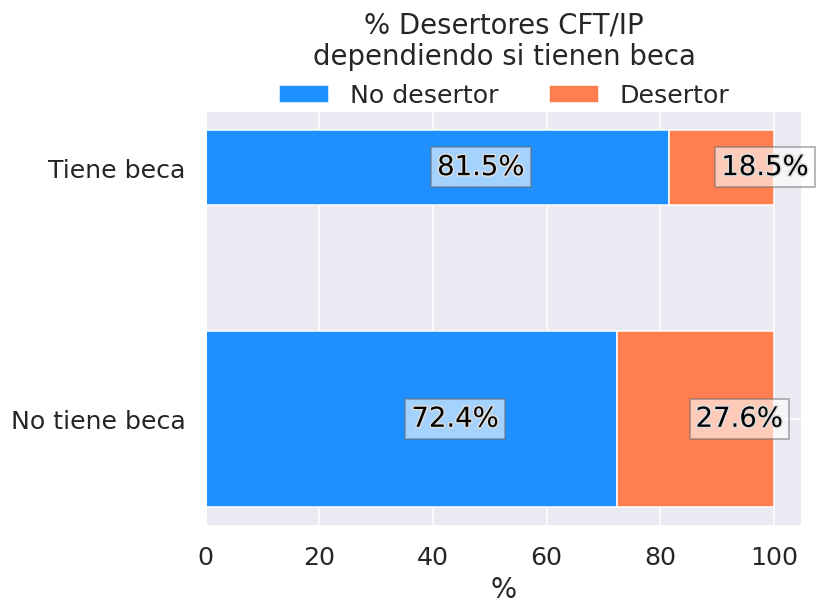

In [26]:
cross_tab_prop = pd.crosstab(index=df_s['beca'],
                             columns=df_s['desertor_1'],
                             normalize="index")

cross_tab = pd.crosstab(index=df_s['beca'],
                        columns=df_s['desertor_1'])

w = list(cross_tab.T.sum()/cross_tab.T.sum().sum())

f, ax = plt.subplots(figsize=(7,5), dpi=110)
#plt.rcParams.update({'font.size': 15})

plt.title("% Desertores CFT/IP\ndependiendo si tienen beca", pad=30, fontsize=18)

b1 = plt.barh(cross_tab_prop.reset_index()['beca'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['beca'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        
        t = plt.text(x=(y_loc - proportion) + (proportion / 2),
             y=n - 0.03,
             s=f'{np.round(proportion * 100, 1)}%', 
             color="black",
             fontsize=18,
            path_effects=[pe.withStroke(linewidth=2, foreground="gainsboro")])
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='dimgray'))
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))
plt.yticks([0, 1], ["No tiene beca", "Tiene beca"])

ax.legend(['No desertor', 'Desertor'], loc ='upper center', ncol=2, bbox_to_anchor=(0.5,1.12));
plt.xlabel("%");

In [18]:
df_s["beca"].value_counts("%")

0.0    0.69872
1.0    0.30128
Name: beca, dtype: float64

# Gratuidad

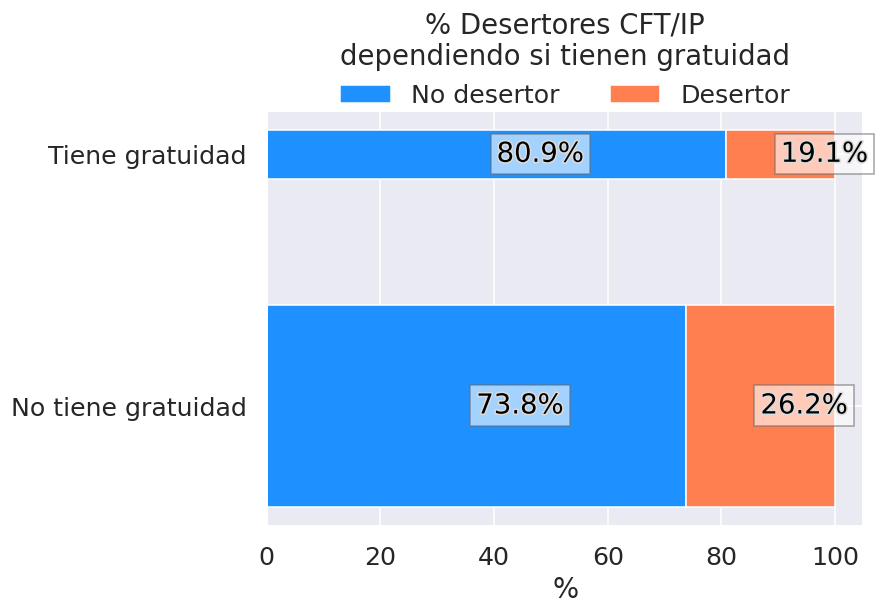

In [28]:
cross_tab_prop = pd.crosstab(index=df_s['gratuidad'],
                             columns=df_s['desertor_1'],
                             normalize="index")

cross_tab = pd.crosstab(index=df_s['gratuidad'],
                        columns=df_s['desertor_1'])

w = list(cross_tab.T.sum()/cross_tab.T.sum().sum())

f, ax = plt.subplots(figsize=(7,5), dpi=110)
#plt.rcParams.update({'font.size': 15})

plt.title("% Desertores CFT/IP\ndependiendo si tienen gratuidad", pad=30, fontsize=18)

b1 = plt.barh(cross_tab_prop.reset_index()['gratuidad'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['gratuidad'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
        
        t = plt.text(x=(y_loc - proportion) + (proportion / 2),
             y=n - 0.03,
             s=f'{np.round(proportion * 100, 1)}%', 
             color="black",
             fontsize=18,
            path_effects=[pe.withStroke(linewidth=2, foreground="gainsboro")])
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='dimgray'))
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))
plt.yticks([0, 1], ["No tiene gratuidad", "Tiene gratuidad"])

ax.legend(['No desertor', 'Desertor'], loc ='upper center', ncol=2, bbox_to_anchor=(0.5,1.12));
plt.xlabel("%");

In [29]:
df_s["gratuidad"].value_counts("%")

0.0    0.804391
1.0    0.195609
Name: gratuidad, dtype: float64

# Únicos en periodo
## Acreditación carrera

In [25]:
def invlogit(x):
    return 1 / (1+np.exp(-x))

In [26]:
unicos = df[df["anio_desercion"] < 2021].drop(columns="anio_desercion").drop_duplicates().sort_values(by=["desertor_1"], ascending=False).drop_duplicates(subset=["mrun"])
vc = unicos[["mrun", "codigo_unico"]].value_counts()
vc[vc>1], unicos.shape

(Series([], dtype: int64), (857650, 18))

In [27]:
unicos["acreditada_carr"].value_counts()

ACREDITADA       451606
NO ACREDITADA    406044
Name: acreditada_carr, dtype: int64

In [28]:
df_acc = pd.get_dummies(
    unicos[["acreditada_carr"]],
    prefix="",
    prefix_sep=""
).drop(columns=["ACREDITADA"])

df_log1 = pd.concat([
    unicos[["desertor_1"]],
    df_acc
], axis=1)

df_log1.columns = [c.replace(" ", "_").replace(".", "") for c in df_log1.columns]
" + ".join(df_log1.columns[1:])

'NO_ACREDITADA'

In [29]:
logit_1 = smf.logit(f"desertor_1 ~ {' + '.join(df_log1.columns[1:])}", data=df_log1).fit()
# logit_1.summary2()

Optimization terminated successfully.
         Current function value: 0.606552
         Iterations 5


In [30]:
# Favorece deserción en 0.13 loggods
coefs = logit_1.summary2().tables[1]
coefs[(coefs["P>|z|"]<0.05) & (coefs["Coef."] > 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
NO_ACREDITADA,0.324593,0.004734,68.561533,0.0,0.315314,0.333872


In [31]:
estimate_y = logit_1.params['Intercept'] + logit_1.params['NO_ACREDITADA']
prob_desercion = invlogit(estimate_y)

print(f"La probabilidad promedio de desertar siendo de carrera no acreditada es de: ", round(prob_desercion, 2))

La probabilidad promedio de desertar siendo de carrera no acreditada es de:  0.33


In [32]:
coefs[(coefs["P>|z|"]<0.05) & (coefs["Coef."] < 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.015026,0.003368,-301.400945,0.0,-1.021627,-1.008426


In [33]:
for r in coefs[(coefs["P>|z|"]<0.05) & (coefs["Coef."] < 0)].index:
    estimate_y = logit_1.params['Intercept'] + logit_1.params[r]
    prob_desercion = invlogit(estimate_y)

    print(f"La probabilidad promedio de desertar siendo de {r} es de: ", round(prob_desercion, 2))

La probabilidad promedio de desertar siendo de Intercept es de:  0.12


## Cant. Becas

In [43]:
unicos["cant_becas"] = unicos["cant_becas"].astype(str)

In [52]:
df_becas = pd.get_dummies(
    unicos[["cant_becas"]],
    prefix="",
    prefix_sep=""
).drop(columns=["1.0"])

df_log2 = pd.concat([
    unicos[["desertor_1"]],
    df_becas
], axis=1)

df_log2.columns = ["desertor_1", "Sin_beca", "Dos_becas", "Tres_becas"]
" + ".join(df_log2.columns[1:])

'Sin_beca + Dos_becas + Tres_becas'

In [53]:
logit_2 = smf.logit(f"desertor_1 ~ {' + '.join(df_log2.columns[1:])}", data=df_log2).fit()
# logit_2.summary2()

         Current function value: 0.594898
         Iterations: 35


/home/giani/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
coefs_2 = logit_2.summary2().tables[1]
coefs_2[(coefs_2["Coef."] > 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Sin_beca,0.740816,0.004844,152.941423,0.0,0.731323,0.75031


In [55]:
coefs_2[(coefs_2["P>|z|"]<0.05) & (coefs_2["Coef."] < 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.248968,0.003665,-340.783441,0.000000e+00,-1.256151,-1.241785
Dos_becas,-1.086003,0.067701,-16.041065,6.601237e-58,-1.218696,-0.953311


In [56]:
for r in coefs_2[(coefs_2["P>|z|"]<0.05)].index:
    estimate_y = logit_2.params['Intercept'] + logit_2.params[r]
    prob_desercion = invlogit(estimate_y)

    print(f"La probabilidad promedio de desertar siendo de {r} es de: ", round(prob_desercion, 2))

La probabilidad promedio de desertar siendo de Intercept es de:  0.08
La probabilidad promedio de desertar siendo de Sin_beca es de:  0.38
La probabilidad promedio de desertar siendo de Dos_becas es de:  0.09
